In [1]:
# !pip install torchinfo
# !pip install pytorch-nlp
# !pip install wandb

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchnlp.nn import LockedDropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch
import joblib
import torch.nn as nn
import matplotlib.pyplot as plt
from torchinfo import summary
import wandb
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Specify the file name
file_name = "household_power_consumption.txt"  # Replace with your actual file name

# Read the data into a DataFrame
df = pd.read_csv(
    file_name,
    sep=';',  # Specify the delimiter
    parse_dates={'DateTime': ['Date', 'Time']},  # Combine 'Date' and 'Time' into 'DateTime'
    infer_datetime_format=True,  # Infer the datetime format for better performance
    low_memory=False  # Handle large files efficiently
)


<ipython-input-3-05f0fab8b720>:5: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
<ipython-input-3-05f0fab8b720>:5: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
<ipython-input-3-05f0fab8b720>:5: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


In [4]:
df.shape

(2075259, 8)

In [5]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df = df.dropna()
df.shape

(2049280, 8)

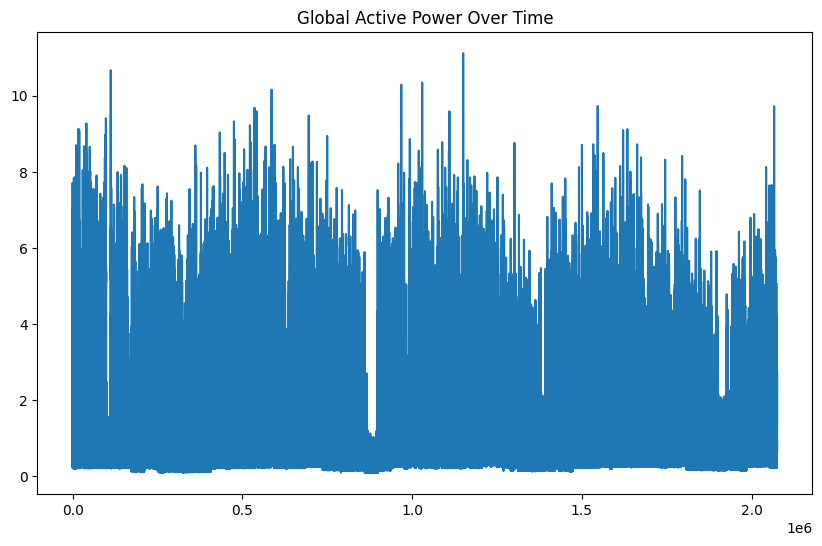

In [6]:
import matplotlib.pyplot as plt

df['Global_active_power'].plot(figsize=(10, 6), title="Global Active Power Over Time")
plt.show()


In [7]:
# Calculate time differences between consecutive rows
time_diffs = df.index.to_series().diff()

# Check the most common interval
print(time_diffs.value_counts().head())  # Most frequent time intervals


1.0       2049208
2.0            38
3.0            14
4.0             2
3724.0          1
Name: count, dtype: int64


In [8]:
df['DateTime'] = pd.to_datetime(df['DateTime'])  # Convert to datetime if not already
df.set_index('DateTime', inplace=True)

In [9]:
print(df.index)  # Check the values of the index
print(type(df.index))

DatetimeIndex(['2006-12-16 17:24:00', '2006-12-16 17:25:00',
               '2006-12-16 17:26:00', '2006-12-16 17:27:00',
               '2006-12-16 17:28:00', '2006-12-16 17:29:00',
               '2006-12-16 17:30:00', '2006-12-16 17:31:00',
               '2006-12-16 17:32:00', '2006-12-16 17:33:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='DateTime', length=2049280, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [10]:
# Create a full range of 1-minute intervals
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='T')  # Continuous 1-min intervals
df = df.reindex(full_index)

<ipython-input-10-aa8659d8efc4>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='T')  # Continuous 1-min intervals


In [11]:
# Interpolate missing values using time-based interpolation
df['Global_active_power'] = df['Global_active_power'].interpolate(method='time')


In [12]:
# Check the shape of the DataFrame
print(df.shape)  # The number of rows should now match the length of full_index

# Inspect the first and last few rows
print(df.head())

(2075259, 7)
                     Global_active_power Global_reactive_power  Voltage  \
2006-12-16 17:24:00                4.216                 0.418  234.840   
2006-12-16 17:25:00                5.360                 0.436  233.630   
2006-12-16 17:26:00                5.374                 0.498  233.290   
2006-12-16 17:27:00                5.388                 0.502  233.740   
2006-12-16 17:28:00                3.666                 0.528  235.680   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
2006-12-16 17:24:00           18.400          0.000          1.000   
2006-12-16 17:25:00           23.000          0.000          1.000   
2006-12-16 17:26:00           23.000          0.000          2.000   
2006-12-16 17:27:00           23.000          0.000          1.000   
2006-12-16 17:28:00           15.800          0.000          1.000   

                     Sub_metering_3  
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2

In [13]:
df['DateTime'] = df.index
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['Year'] = df['DateTime'].dt.year

# Normalize or encode periodic features
df['DayOfWeek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
df['DayOfWeek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)

df['Year_sin'] = np.sin(2 * np.pi * (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min()))
df['Year_cos'] = np.cos(2 * np.pi * (df['Year'] - df['Year'].min()) / (df['Year'].max() - df['Year'].min()))

In [14]:
df.shape

(2075259, 14)

In [15]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3', 'DateTime', 'DayOfWeek', 'Year', 'DayOfWeek_sin',
       'DayOfWeek_cos', 'Year_sin', 'Year_cos'],
      dtype='object')

In [ ]:
data = df[['Global_active_power', 'DayOfWeek_sin', 'DayOfWeek_cos']].copy()

joblib.dump(data, 'dataframe.pkl')